# Cosmopolitan analyses

As the world becomes more interconnected, the risk of cultural misunderstandings increases. Understanding what countries people are interested in and know about can consequently help us determine where there might be a high risk of faux pas and more education about global history and politics might help. We measured people's knowledge of other countries by using [Google Trends](https://www.google.com/trends/) to compare how much countries are searched for and search for each other.

Our measure for how much one Country A cares about Country B is going to be the log10 ratio of how much Country A searches for Country B divided by how much Country B searches for Country B. For example, [this search](https://www.google.com/trends/explore#q=%2Fm%2F0f8l9c%2C%20%2Fm%2F09c7w0&geo=US&date=1%2F2005%20133m&cmpt=q&tz=Etc%2FGMT%2B7) is going to allow us to see how much Americans care about the French. If we look at the summary bar graph, we're going to take log10(5/79). So, rule of thumb, less negative scores indicate the country is more searched.

After loading our data, I'm going to

1) **<a href='#country_pop'>Find what countries people know the most about</a>**<br>
2) **<a href='#country_by_country'>Find out what countries each country tends to search for </a> **

So that we can figure out where there are gaps in people's world knowledge

In [57]:
%matplotlib inline

import csv
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from geopy.distance import vincenty
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set(style="white", color_codes=True)

In [310]:
# The lm code keeps setting off errors, but doesn't seem to be affecting anything
import warnings

# http://statsmodels.sourceforge.net/stable/examples/notebooks/generated/mixed_lm_example.html
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    likev = mdf.profile_re(0, dist_low=0.00001, dist_high=0.1)

Let's read the raw data into a csv

In [2]:
trends_df=pd.read_csv('country_trends.csv',header=None)
trends_df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,NaN,Nigeria,Japan,Pakistan,United States,France,Russia,Indonesia,Mexico,Rwanda,...,Germany,Spain,Thailand,South Africa,India,Australia,Brazil,Canada,Belgium,Netherlands
1,Nigeria,68,1,0,14,2,1,0,0,0,...,2,1,0,3,2,2,1,5,1,1
2,Japan,0,66,1,16,3,2,4,3,0,...,2,2,3,2,3,4,8,2,1,1
3,Pakistan,0,1,70,4,0,1,0,0,0,...,1,0,1,0,5,2,0,2,0,0
4,United States,1,6,2,80,5,5,1,14,0,...,5,4,2,2,9,6,8,12,1,1


And now let's turn it into our country caring measure

In [3]:
self_df=pd.DataFrame({'self_num':[int(trends_df.iloc[i,i]) for i in range(1,41)],
 'Searcher':[trends_df.iloc[0,i] for i in range(1,41)]})

In [120]:
searcher=[]
searchee=[]
search_num=[]
for s_er in range(1,41):
    for s_ee in range(1,41):
        if s_er!=s_ee:
            searcher.append(trends_df.iloc[s_er,0])
            searchee.append(trends_df.iloc[0,s_ee])        
            search_num.append(int(trends_df.iloc[s_er,s_ee]))
search_df=pd.DataFrame({'Searcher':searcher,'Searchee':searchee,'search_num':search_num})
search_df=pd.merge(search_df,self_df,how='inner',on='Searcher')

count_2= (search_df.loc[:,'search_num']+(search_df.loc[:,'self_num']/(100)))
norm_2= (search_df.loc[:,'self_num']+(search_df.loc[:,'self_num']/(100)))
search_df.loc[:,'search_score']=np.log10(count_2/norm_2)
search_df.head()

,Searchee,Searcher,search_num,self_num,search_score
0,Japan,Nigeria,1,68,-1.611521
1,Pakistan,Nigeria,0,68,-2.004321
2,United States,Nigeria,14,68,-0.670104
3,France,Nigeria,2,68,-1.408695
4,Russia,Nigeria,1,68,-1.611521


<a id='country_pop'></a>
# Country popularity

Ok, first analysis--What countries were searched the most and do people probably know the most about?

In [121]:
mean_searchee=search_df.loc[:,['Searchee','search_score']].groupby('Searchee').mean().reset_index()
mean_searchee.columns=['Searchee', 'mean']
std_searchee=search_df.loc[:,['Searchee','search_score']].groupby('Searchee').std()
num_search=np.sqrt(search_df.loc[:,['Searchee','search_score']].groupby('Searchee').size())
sem_searchee=std_searchee.divide(num_search,axis=0).reset_index()
sem_searchee.columns=['Searchee', 'SEM']

searchee_df=pd.merge(mean_searchee,sem_searchee,how='inner',on='Searchee')
searchee_df=searchee_df.sort_values(by='mean').reset_index()

In [122]:
searchee_df

,index,Searchee,mean,SEM
0,20,Liberia,-2.004321,0.000000
1,12,Haiti,-1.995291,0.009030
2,29,Rwanda,-1.984597,0.019724
3,39,Yemen,-1.969791,0.024906
4,26,North Korea,-1.963354,0.024140
5,22,Nepal,-1.931742,0.028782
6,0,Afghanistan,-1.899238,0.032266
7,38,Venezuela,-1.892080,0.040410
8,19,Jordan,-1.877866,0.035829
9,14,Indonesia,-1.869191,0.044479


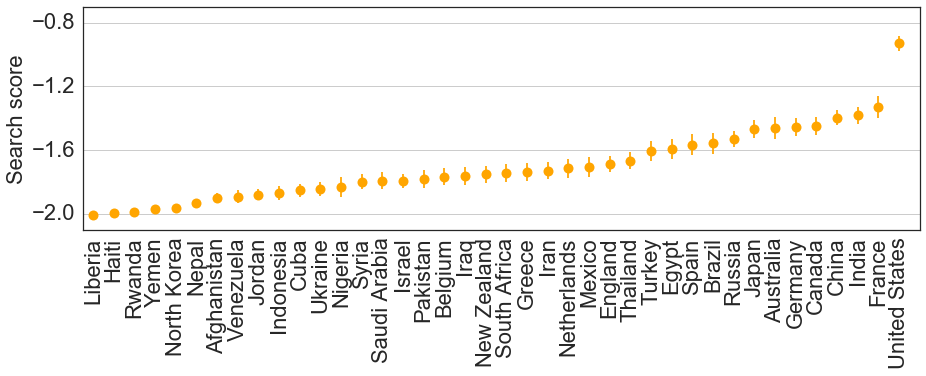

In [344]:
plt.figure(figsize=(15,4))
ax=plt.axes()
ax.yaxis.grid(True)
plt.errorbar(range(len(searchee_df)), searchee_df['mean'], yerr=searchee_df['SEM'],\
             c='orange',fmt='o',markersize=10)

plt.ylabel('Search score',fontsize='22')
plt.xticks(range(len(searchee_df)), searchee_df['Searchee'], rotation='90',fontsize=22)
plt.yticks([-2,-1.6,-1.2,-.8],fontsize=22)
plt.axis([-.5, len(searchee_df), -2.1, -.7])
plt.show()

<a id='country_by_country'></a>
# Country by Country Analyses

So far we've seen that certain countries are searched more often (more "popular" we might say) overall. How do these patterns vary depending on what country is doing the searching?

In [189]:
search_mat=search_df.pivot('Searchee','Searcher','search_score')
search_mat2=search_mat.loc[list(searchee_df['Searchee']),list(searchee_df['Searchee'])]
search_mat2.head()

Searcher,Liberia,Haiti,Rwanda,Yemen,North Korea,Nepal,Afghanistan,Venezuela,Jordan,Indonesia,...,Brazil,Russia,Japan,Australia,Germany,Canada,China,India,France,United States
Searchee,,,,,,,,,,,,,,,,,,,,,
Liberia,NaN,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,...,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321
Haiti,-2.004321,NaN,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,...,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-1.652139
Rwanda,-1.235088,-2.004321,NaN,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,...,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321
Yemen,-2.004321,-2.004321,-2.004321,NaN,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,...,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321
North Korea,-2.004321,-2.004321,-2.004321,-2.004321,NaN,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,...,-2.004321,-2.004321,-1.260384,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-1.652139


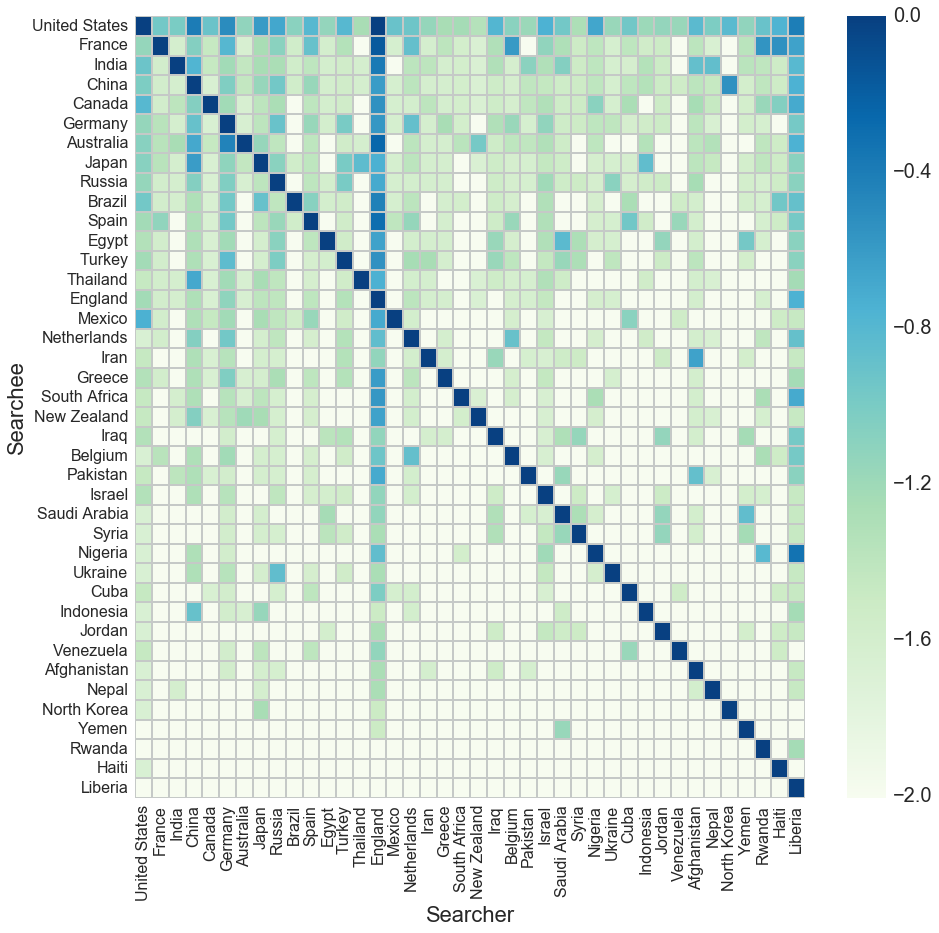

In [340]:
search_mat=search_df.pivot('Searchee','Searcher','search_score')
search_mat2=search_mat.loc[list(searchee_df['Searchee'])[::-1],list(searchee_df['Searchee'])[::-1]]
for i in range(0,40):
    search_mat2.iloc[i,i]=0 # Setting self-search to the max

plt.figure(figsize=(15,14))
#plt.figure(figsize=(4,4))
hm=sns.heatmap(search_mat2, linewidths=1,linecolor='#c5c9c7',vmax=0,cmap="GnBu")
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=20)
xt=plt.xticks(fontsize=16)
yt=plt.yticks(fontsize=16)
xl=plt.xlabel('Searcher',fontsize='22')
yl=plt.ylabel('Searchee',fontsize='22')


# Takeaways

From here we can see a few salient patterns:

* People, unsurprisingly, search for the United States a LOT
* Inversely, the English are exceptionally cosmopolitan in their search habits. This is particularly strong for their former colonies (Nigeria, Pakistan, New Zealand, South Africa, Australia, India)
* Americans are very aware of large European, North American and Asian countries, but their knowledge of countries in Africa, the Middle East and South America (sans Brazil) is really lacking.